In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.fft as fft
import scipy.signal as sig
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from scipy import interpolate

#design output
#v=0 critical current v stuff
#time series for quiet squid
#time series for d

In [2]:
def noisyRK4(s,th,alpha,betaL,betaC,kappa,eta,rho,i,phia,tau,derivsRK,vn10,vn20,vn11,vn21,vn12,vn22):
    """"""
    
#   Runge-Kutta integrator 4th order
# INputs
#   x           -   current values of dependent variable
#   t           -   independent variable usually time
#   tau         -   step size usually time step
#   derivsRK    -   RHS of the ODE, fn defined somewhere
#   param       -   extra parameters passed to deriv fn
# Output
#   xout        -   new value of dependent variable after a step size tau

    # noisySQUIDrk(s,th,alpha,beta,eta,rho,i,phia,vn1,vn2)
    
    half_tau = 0.5*tau
    
    F1 = derivsRK(s,th,alpha,betaL,betaC,kappa,eta,rho,i,phia,vn10,vn20)             # use current voltage noise
    th_half = th + half_tau
    stemp = s + half_tau*F1
    
    F2 = derivsRK(stemp,th_half,alpha,betaL,betaC,kappa,eta,rho,i,phia,vn11,vn21)    # use half-tau step voltage noise
    stemp = s + half_tau*F2
    
    F3 = derivsRK(stemp,th_half,alpha,betaL,betaC,kappa,eta,rho,i,phia,vn11,vn21)    # use half-tau step voltage noise
    th_full = th + tau
    stemp = s + tau*F3
    
    F4 = derivsRK(stemp,th_full,alpha,betaL,betaC,kappa,eta,rho,i,phia,vn12,vn22)    # use full-tau step voltage noise
    sout = s + tau/6.*(F1 + F4 + 2.*(F2 + F3))
    return sout   

In [3]:
def noisySQUIDrk(s,th,alpha,betaL,betaC,kappa,eta,rho,i,phia,vn1,vn2):
    
#    Returns RHS of RSJ ODE; used by rk4
# Inputs
#    s      -   State vector [theta,del1, del2, ddel1/dth, ddel2/dth, d^2del1/dth^2, d^2del2/dth^2]
#    other parameters are scalar values
# Ouputs
#    deriv  -   Derivaties [ddel1/dth, ddel2/dth, d^2del1/dth^2, d^2del2/dth^2]

    #alpha = param[0]; beta = param[1];
    #eta = param[2]; rho = param[3]
    #i = param[4]; phia = param[5]
    #del1 = s[0] # del_1(theta)
    #del2 = s[1] # del_2(theta)
    j = (s[0] - s[1] - 2*np.pi*phia)/(np.pi*betaL) - eta*i/2
    
    dddel1 = (.5*i-j-(1-alpha)*np.sin(s[0])-(1-rho)*s[2])/((1-kappa)*betaC)
    dddel2 = (.5*i+j-(1+alpha)*np.sin(s[1])-(1+rho)*s[3])/((1+kappa)*betaC)
        
    ddel1 = (.5*i-j-(1-alpha)*np.sin(s[0])-(1-kappa)*betaC*dddel1)/(1-rho) + vn1 # ddel1/dth
    ddel2 = (.5*i+j-(1+alpha)*np.sin(s[1])-(1+kappa)*betaC*dddel2)/(1+rho) + vn2 # ddel2/dth
    
    deriv = np.array([ddel1,ddel2,dddel1,dddel2])
    return(deriv)

In [12]:
# Inputs
#                0    1    2    3   4   5
#     par = [alpha, betaL, betaC, eta, rho, i, phia]
#     s = [del1(0),del2(0),ddel1(0),ddel2(0),dddel1(0),dddel2(0)]
#     tau = time step size
#     nStep = number of points
# Output
#           0     1    2   3   4           5           6
#     X = [theta,del1,del2,j,ddel1/dtheta,ddel2/dtheta,v]
def noisySQUID(nStep,tau,s,alpha,betaL,betaC,kappa,eta,rho,i,phia,Gamma):
    # change state vector s to include all the derivs
    # little s denotes a 1-d vector of, current values
    # big S denotes the output array of all s, a 2-d array in time
    ## NOISE ##
    # set an appropriate variance based on Gamma.
    # variance is twice normal because freq of noise
    # is twice that of the sampling freq so that rk4 has
    # a noise value to use at each half tau step
    var = 4*Gamma/tau
    sd = var**.5
    
    # make two time series of noise voltages
    # lowercase designators are current values, uppercase are arrays in time
    VN1 = np.zeros(2*nStep+1)
    VN2 = np.zeros(2*nStep+1)
    for ist in range(2*nStep+1):
        VN1[ist] = np.random.normal(0,sd)
        VN2[ist] = np.random.normal(0,sd)
    
    # DATA STRUCTURE
    # S = [theta,del1,del2,ddel1,ddel2,dddel1,dddel2,j,v]
    S = np.zeros([8,nStep],float)
    # set initial conditions
    theta = 0.
    S[0,0] = theta
    S[1,0] = s[0] # del1
    S[2,0] = s[1] # del2
    j = (s[0] - s[1] - 2*np.pi*phia)/(np.pi*betaL) - eta*i/2
    S[3,0] = (.5*i-j-(1-alpha)*np.sin(s[0])-(1-kappa)*betaC*s[4])/(1-rho) # ddel1
    S[4,0] = (.5*i+j-(1+alpha)*np.sin(s[1])-(1+kappa)*betaC*s[5])/(1+rho) # ddel2
    S[5,0] = (.5*i-j-(1-alpha)*np.sin(s[0])-(1-rho)*s[2])/((1-kappa)*betaC) # dddel1
    S[6,0] = (.5*i+j-(1+alpha)*np.sin(s[1])-(1+rho)*s[3])/((1+kappa)*betaC) # dddel2
    
    s = np.copy(S[1:5,0])
    
    for iStep in range(1,nStep):
        vn10 = VN1[2*iStep-2]
        vn20 = VN2[2*iStep-2]
        vn11 = VN1[2*iStep-1]
        vn21 = VN2[2*iStep-1]
        vn12 = VN1[2*iStep]
        vn22 = VN2[2*iStep]
        
        #   noisyRK4(s,th,alpha,beta,eta,rho,i,phia,tau,derivsRK,vn10,vn20,vn11,vn21,vn12,vn22)
        s = noisyRK4(s,theta,alpha,betaL,betaC,kappa,eta,rho,i,phia,tau,noisySQUIDrk,vn10,vn20,vn11,vn21,vn12,vn22)
        
        S[0,iStep] = theta # time theta
        S[1,iStep] = s[0] # del1
        S[2,iStep] = s[1] # del2
        S[3,iStep] = s[2] # ddel1
        S[4,iStep] = s[3] # ddel2
        
        #S[5,iStep] =  # dddel1
        #S[6,iStep] =  # dddel2
        
        theta = theta + tau
        
    # S[5,:] = 
    # S[6,:] = 
    S[6] = S[3]*(1+eta)/2  + S[4]*(1-eta)/2
        
    return(S)    

In [13]:
# noisySQUID(nStep,tau,s,alpha,beta,eta,rho,i,phia,Gamma)
nStep = 8000
tau = 0.1
s = np.array([0.,0.,0.,0.,0.,0.])
alpha = 0.
betaL = 1.
betaC = 1.
kappa = 0.
eta = 0.
rho = 0.
i = 1.5
phia = 0.5
Gamma = 0.05

In [14]:
# noisySQUID(nStep,tau,s,alpha,beta,eta,rho,i,phia,Gamma)
SQ = noisySQUID(nStep,tau,s,alpha,betaL,betaC,kappa,eta,rho,i,phia,Gamma)

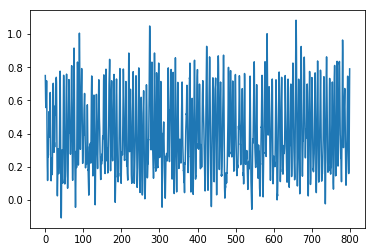

In [15]:
plt.plot(SQ[0,],SQ[6,])

Need to make $i(\bar{v},\phi_a)$ curves at various levels of $\phi_a = \{0,0.25,0.5\}$ with the prameters $\beta=1.0$, $\Gamma=0.05$ and $\alpha=\eta=\rho=0$ to compare with Tesche-Clarke Fig 12(a).

What we **really** want is to develop the transfer function, $\bar{v}(i,\phi_a)$. To match Fig 12(b), I will need to match the density of fluxes used to build curves, namely $\phi_a=[0,0.5]$ and $i=[0,3.5]$.

**Specifically** I need $i=\{0.8,1.0,1.2,1.4,1.6,1.8,2.0,2.2,2.4,2.6,2.8,3.0\}$ and $\phi_a=\{0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5\}$

I'd rather run a set of routines *once* that develops a surface, then do contor plots from different planes to get something to compare to Fig 12(a) and Fig 12(b), rather than doing two sets of runs, one sweeping $i$ and one sweeping $\phi_a$.

In [ ]:
# noisySQUID(nStep,tau,s,alpha,beta,eta,rho,i,phia,Gamma)
nStep = 64000
tau = 0.1
s = np.array([0.,0.])
alpha = 0.
beta = 1.
eta = 0.
rho = 0.
Gamma = 0.05
i = np.arange(0.8,3.1,0.1)#i = np.arange(1,2.51,0.075)#i = np.arange(1,2.55,0.05)#i = np.arange(0.8,3.1,0.1)
phia = np.arange(0.,.55,.025)#phia = np.arange(.2,.31,.005)#phia = np.arange(0.,.5,.03125)#phia = np.arange(0.,.55,.025)

In [ ]:
i.shape

In [ ]:
%%time 
# cell magic timer to see how long this takes...
m = len(i)
n = len(phia)
l = int(nStep*0.05)
N = m*n
vp = np.zeros([n,m]) # average v at fixed phia
iv = np.zeros([m,n]) # average v at fixed i

for j in range(0,m):
    for k in range(0,n):
        X = noisySQUID(nStep,tau,s,alpha,beta,eta,rho,i[j],phia[k],Gamma)
        v = np.average(X[6,l:]) # average voltage
        vp[k,j] = v 
        iv[j,k] = v

In [ ]:
#np.savetxt("test.csv", vp, delimiter=",")
#np.savetxt("test.csv", iv, delimiter=",")
#vp = np.genfromtxt('vp.csv',delimiter=',')
#iv = np.genfromtxt('iv.csv',delimiter=',')

In [ ]:
fig = plt.figure(figsize=[9,6])

ax1 = plt.subplot(1,2,1)
ax1.plot(phia,vp[:,0],label=round(i[0],2))
for h in range(1,len(vp[0,:])):
    ax1.plot(phia,vp[:,h],label=round(i[h],2))
ax1.set(title=r'$i(\bar{v},\phi_a)$',
        xlabel=r'applied flux $\phi_a$',
        ylabel=r'average voltage $\bar{v}$')
ax1.legend(loc=6,title=r'$\phi_a$')

ax2 = plt.subplot(1,2,2)
ax2.plot(vp[0,:],i,label=round(phia[0],3))
for h in range(1,len(vp[:,0])):
    ax2.plot(vp[h,:],i,label=round(phia[h],3))
ax2.set(title=r'$\phi_a(\bar{v},i)$',
        xlabel=r'average voltage $\bar{v}$',
        ylabel=r'bias current $i$')
ax2.legend(title=r'$i$')
fig.tight_layout()
fig.savefig('test.jpg')

In [ ]:
plt.plot(phia,vp[:,0],label=round(i[0],2))
plt.plot(phia,vp[:,4],label=round(i[4],2))
plt.plot(phia,vp[:,8],label=round(i[8],2))
plt.plot(phia,vp[:,12],label=round(i[12],2))
plt.plot(phia,vp[:,16],label=round(i[16],2))
plt.plot(phia,vp[:,20],label=round(i[20],2))
#for h in range(1,len(vp[0,:])):
    #plt.plot(phia,vp[:,h],label=round(i[h],2))
plt.title(r'$i(\bar{v},\phi_a)$')
plt.xlabel(r'applied flux $\phi_a$')
plt.ylabel(r'average voltage $\bar{v}$')
plt.legend(loc=6)

In [ ]:
plt.plot(vp[0,:],i,label=round(phia[0],3))
plt.plot(vp[10,:],i,label=round(phia[10],3))
plt.plot(vp[20,:],i,label=round(phia[20],3))
#for h in range(1,len(vp[:,0])):
    #plt.plot(vp[h,:],i,label=round(phia[h],3))
plt.title(r'$\phi_a(\bar{v},i)$')
plt.xlabel(r'average voltage $\bar{v}$')
plt.ylabel(r'bias current $i$')
plt.legend()

In [ ]:
fig = plt.figure()
ax = fig.gca(projection='3d')
x = np.copy(i)
y = np.copy(phia)
x, y = np.meshgrid(y, x)
z = np.copy(iv)
ax.plot_wireframe(x, y, z) # cmap='terrain'
# note the xlabel and ylabel are reversed, this is correct
ax.set(ylabel=r'bias current $i$',
       xlabel=r'applied flux $\phi_a$',
       zlabel=r'average voltage $\bar{v}$',
      title = r'$\bar{v}(i,\phi_a)$; $\Gamma=0.05$, $\beta=1$, $\alpha=\eta=\rho=0$')
fig.tight_layout()
fig.savefig('test.jpg')

In [ ]:
## smooth and interpolate over a grid lx dense ##
l = 1
inew = np.arange(0.8,3.1,0.1/l)#inew = np.arange(1,2.55,0.05/l)#inew = np.arange(0.8,3.1,0.1/l)
phianew = np.arange(0.,.55,.025/l)#phianew = np.arange(0.,.5,.03125/l)#phianew = np.arange(0.,.55,.025/l)

x, y = np.meshgrid(phia,i)
xnew, ynew = np.meshgrid(phianew,inew)
z = np.copy(iv)
tck = interpolate.bisplrep(y, x, iv, s=.00) # s = smoothing
ivi = interpolate.bisplev(ynew[:,0], xnew[0,:], tck)
ivi.shape

In [ ]:
fig = plt.figure()
ax = fig.gca(projection='3d')
#x = np.copy(i)
#y = np.copy(phia)
#x, y = np.meshgrid(y, x)
#z = np.copy(ivi)
ax.plot_wireframe(xnew, ynew, ivi) # cmap='terrain'
# note the xlabel and ylabel are reversed, this is correct
ax.set(ylabel=r'bias current $i$',
       xlabel=r'applied flux $\phi_a$',
       zlabel=r'average voltage $\bar{v}$',
      title = r'$\bar{v}(i,\phi_a)$ smoothed; $\Gamma=0.05$, $\beta=1$, $\alpha=\eta=\rho=0$')
fig.tight_layout()
fig.savefig('test.jpg')

In [ ]:
## Transfer function ##
# need partial dvbar/dphia as a function of i
# that is the transfer function

# first get derivative of surface vbar(i,phia)
# gradient() returns one surface of the value of the partial deriv
# for each dependent dimension. So two sets for us: dvbar/di and 
# dvbar/dphia. We are interested in the second here.


dv = np.gradient(ivi,inew,phianew) # bingo, dv[1] = dvbar(i,phia)/dphia
                     # dv[0] = dvbar(i,phia)/di

# Next we can peep the surface

In [ ]:
fig = plt.figure()
ax = fig.gca(projection='3d')
x = np.copy(inew)
y = np.copy(phianew)
x, y = np.meshgrid(y, x)
z = np.copy(dv[1]) # partial dvbar/dphia
ax.plot_wireframe(x, y, z) # cmap='terrain'
# note the xlabel and ylabel are reversed, this is correct
ax.set(ylabel=r'bias current $i$',
       xlabel=r'applied flux $\phi_a$',
       zlabel=r'transfer function $\partial\bar{v}/\partial\phi_a$',
      title = r'$\partial\bar{v}(i,\phi_a)/\partial\phi_a$ smoothed; $\Gamma=0.05$, $\beta=1$, $\alpha=\eta=\rho=0$')
ax.view_init(65,-60)
fig.tight_layout()
fig.savefig('test.jpg')

# This looks correct to me

In [ ]:
fig, ax = plt.subplots()
dv1 = np.copy(dv[1])
ax.plot(inew,dv1[:,int(5*l)],label=round(phianew[int(5*l)],3))
ax.plot(inew,dv1[:,int(10*l)],label=round(phianew[int(10*l)],3))
ax.plot(inew,dv1[:,int(-6*l)],label=round(phianew[int(-6*l)],3))
ax.set(title=r'$\partial \bar{v}(i,\phi_a)/\partial\phi_a$; $\Gamma=0.05$, $\beta=1$, $\alpha=\eta=\rho=0$',
      xlabel=r'bias current, $i$',
      ylabel=r'transfer function, $(\partial\bar{v}/\partial\phi_a)_i$')
ax.legend(title=r'$\phi_a$')
fig.tight_layout()